In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report

import joblib
import itertools

import preprocessing as pp

from importlib import reload
pd.options.mode.chained_assignment = None

In [97]:
reload(pp);

In [3]:
#Load dataset, regroup classification in superclasses, and keep only those with data > 5000
df = pp.load_datasets()
df = pp.prepare_target(df)

Complete DataFrame has 471149 lines and 16 columns
Final DataFrame has 288179 lines and 16 columns after removing all classes with less than 5000 items


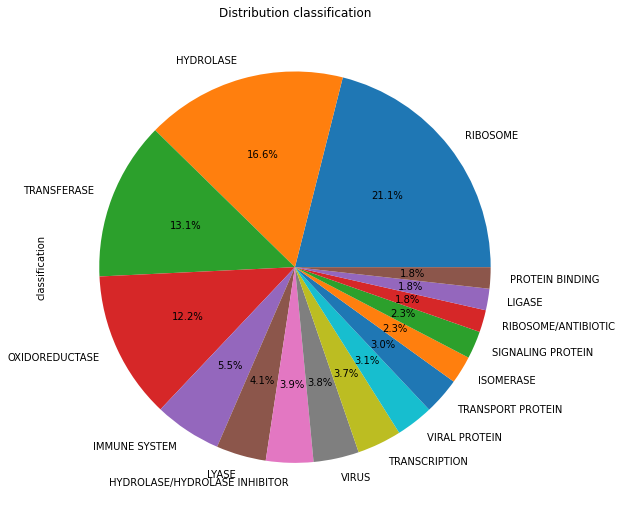

In [4]:
df.classification.value_counts().plot(kind="pie", figsize=(9,9), title='Distribution classification', autopct='%1.1f%%');

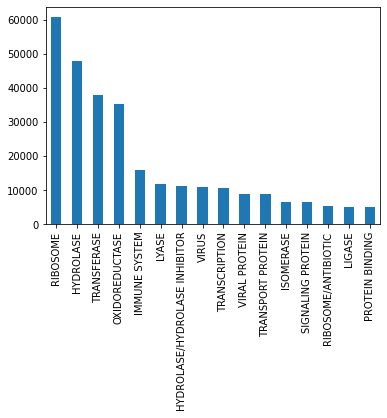

In [5]:
df.classification.value_counts().plot(kind='bar');
#Other classes regroup several classes, worth being kept to be able to check if the model can 
#properly detect that. Studying the behavior of this other_classes may also be relevant

In [6]:
#Get  train / test data 
data = df.drop('classification', axis = 1)
target = df.classification
X_train, X_test, y_train,  y_test = train_test_split(data, target, test_size=0.3, random_state=452)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201725, 15), (86454, 15), (201725,), (86454,))

In [7]:
#Feature selection
rfe = RFE(ExtraTreesClassifier(), n_features_to_select=6,verbose=1)

In [8]:
#Pipeline
# We made predictions without Features reduction
# Only 12 features, and all of them seems important to not have more unbalanced data, no need to reduce
# Also, it does not take much time to take all 12 than reduce to 8 or Even 4 as suggested by RFECV test
steps = [('preprocessing', pp.PreprocessingTransformer(verbose=True)),
         ('rfe', rfe),
         ('clf', ExtraTreesClassifier())
         ]


pipe = Pipeline(steps, verbose=True)
pipe.fit(X_train, y_train)

-- Fit done -- 
1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
[Pipeline] ..... (step 1 of 3) Processing preprocessing, total=   4.4s
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
[Pipeline] ............... (step 2 of 3) Processing rfe, total= 2.4min
[Pipeline] ............... (step 3 of 3) Processing clf, total=  27.3s


Pipeline(steps=[('preprocessing', PreprocessingTransformer()),
                ('rfe',
                 RFE(estimator=ExtraTreesClassifier(), n_features_to_select=6,
                     verbose=1)),
                ('clf', ExtraTreesClassifier())],
         verbose=True)

In [9]:
print("score on Train set:", pipe.score(X_train, y_train))
print("score on Test set:", pipe.score(X_test, y_test))

1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
score on Train set: 0.9996529929359276
1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
score on 

In [10]:
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
                               precision    recall  f1-score   support

                    HYDROLASE       0.82      0.90      0.86     14438
HYDROLASE/HYDROLASE INHIBITOR       0.90      0.90      0.90      3415
                IMMUNE SYSTEM       0.92      0.94      0.93      4769
                    ISOMERASE       0.94      0.83      0.88      2040
                       LIGASE       0.94      0.77      0.85      1517
                        LYASE       0.96      0.88      0.91      3515
               OXIDOREDUCT

In [11]:
def plot_confusion_matrix(cm, classes):

    plt.figure(figsize=(15,15))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ', fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=12,color='black')
    plt.xlabel('Predicted label',fontsize=12,color='black' )
    np.set_printoptions(precision=2)

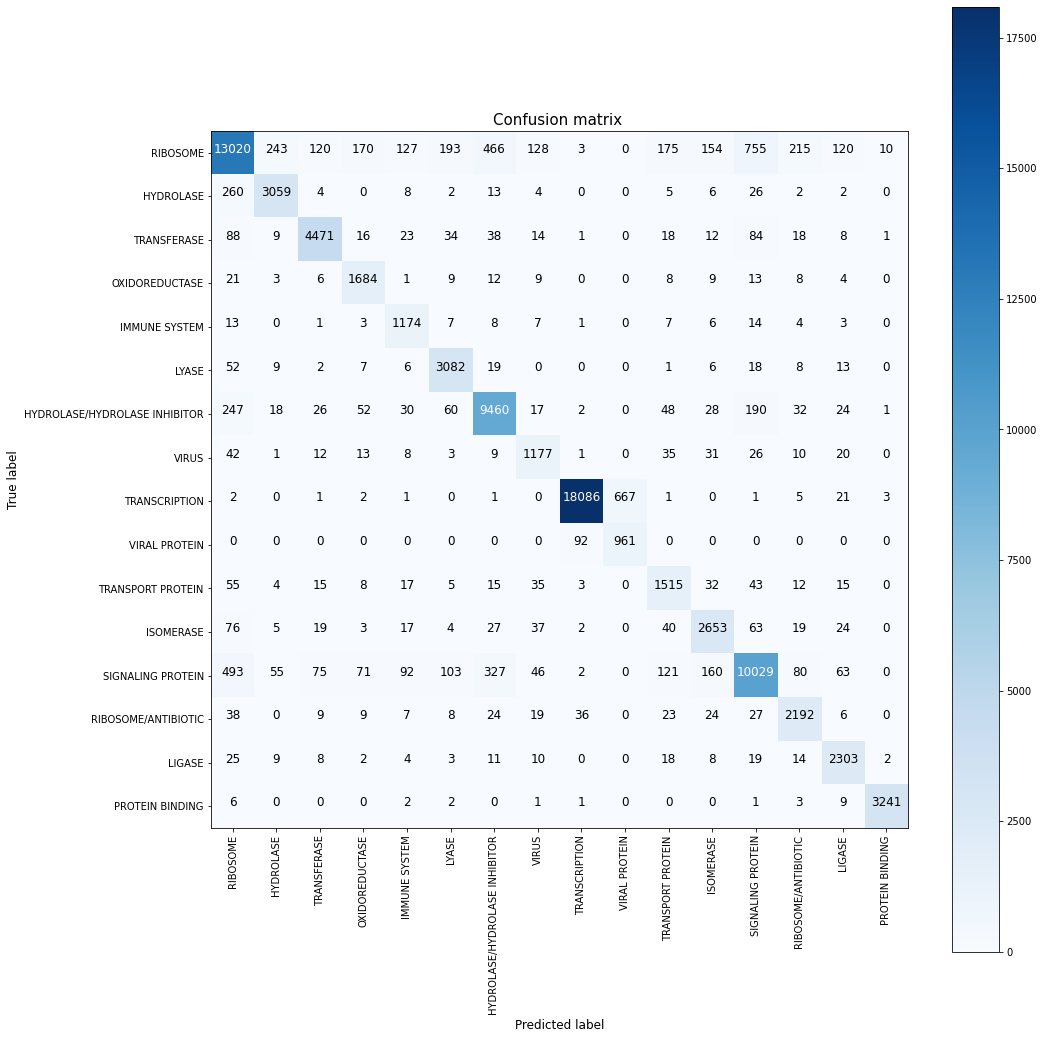

In [12]:
cm = confusion_matrix(y_pred,y_test)
plot_confusion_matrix(cm, y_train.value_counts().index)

In [35]:
names = pipe['clf'].feature_names_in_
importances = pipe['clf'].feature_importances_
forest_importances = pd.Series(importances, index=names)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

AttributeError: 'ExtraTreesClassifier' object has no attribute 'feature_names_in_'

In [27]:
# Test des modèles sans feature selection 

steps_2 = [('preprocessing', pp.PreprocessingTransformer(verbose=True)),
         ('clf', ExtraTreesClassifier())
         ]


pipe_no_rfe = Pipeline(steps_2, verbose=True)
pipe_no_rfe.fit(X_train, y_train)

-- Fit done -- 
1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   4.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  21.2s


Pipeline(steps=[('preprocessing', PreprocessingTransformer()),
                ('clf', ExtraTreesClassifier())],
         verbose=True)

In [30]:
print("score on Train set:", pipe_no_rfe.score(X_train, y_train))
print("score on Test set:", pipe_no_rfe.score(X_test, y_test))

1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
score on Train set: 0.9996529929359276
1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
score on 

In [31]:
y_pred_no_rfe = pipe_no_rfe.predict(X_test)
print(classification_report(y_test, y_pred_no_rfe))

1.Drop useless columns
2.Replace missing values in X
3.Reduce modalities
4.Correct skewness
5.scale and encode categ values
-- Preprocessing done -- 
[Columns] :  Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'macromoleculeType_DNA', 'macromoleculeType_Protein',
       'macromoleculeType_RNA', 'phValue_acide', 'phValue_basique',
       'phValue_neutre'],
      dtype='object')
                               precision    recall  f1-score   support

                    HYDROLASE       0.80      0.90      0.85     14438
HYDROLASE/HYDROLASE INHIBITOR       0.89      0.78      0.83      3415
                IMMUNE SYSTEM       0.93      0.93      0.93      4769
                    ISOMERASE       0.94      0.83      0.89      2040
                       LIGASE       0.93      0.78      0.85      1517
                        LYASE       0.95      0.88      0.91      3515
               OXIDOREDUCT

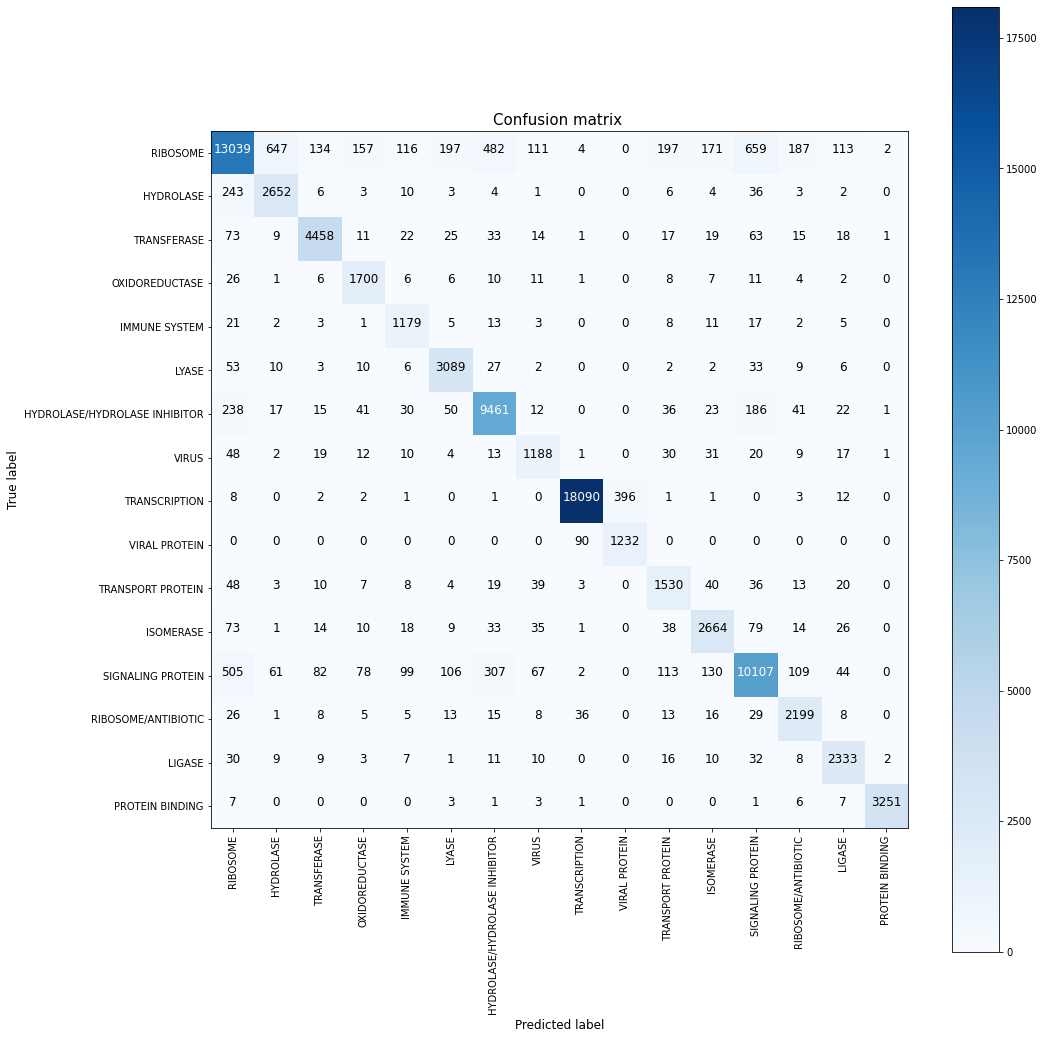

In [32]:
cm2 = confusion_matrix(y_pred_no_rfe,y_test)
plot_confusion_matrix(cm2, y_train.value_counts().index)

In [ ]:
# Pas de grandes différences entre 6 et 15 variables en input.
# Les variables numériques initiales constituent la base de décision du modèle

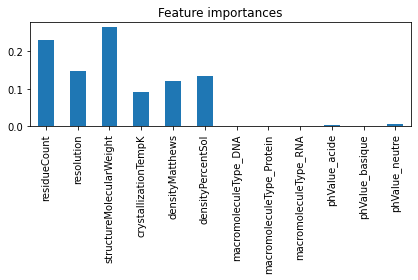

In [34]:
names = pipe_no_rfe['clf'].feature_names_in_
importances = pipe_no_rfe['clf'].feature_importances_
forest_importances = pd.Series(importances, index=names)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

In [36]:
#Save complete classifier
joblib.dump(pipe['clf'], '../models/prot_clf.joblib')

['../models/prot_clf.joblib']

In [37]:
#Safe preprocessing class
joblib.dump(pipe['preprocessing'], '../models/prot_preprocessing.joblib')


['../models/prot_preprocessing.joblib']

In [38]:
#Save no rfe classfier
joblib.dump(pipe['clf'], '../models/prot_clf_no_rfe.joblib')

['../models/prot_clf_no_rfe.joblib']